# Jimmy Garoppolo Passing Efficiency 2019 vs. 2021

In [1]:
import nflfastpy as npy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from matplotlib.patches import Polygon
import pandas as pd
import numpy as np
import urllib
from PIL import Image

### Load team color and logo data

In [2]:
team_logo_df = npy.load_team_logo_data()

### Load 2019 and 2021 play-by-play data

In [3]:
df_2019 = npy.load_pbp_data(2019)
df_2021 = npy.load_pbp_data(2021)

### Get Jimmy Garoppolo stats for both seasons

In [4]:
df_jimmy_2019 = df_2019[
    ((df_2019["passer_player_name"] == "J.Garoppolo") |
    (df_2019["rusher_player_name"] == "J.Garoppolo") |
    (df_2019["receiver_player_name"] == "J.Garoppolo")) &
    (df_2019["two_point_attempt"] == 0) &
    (df_2019["week"] <= 17)
].copy()

df_jimmy_2021 = df_2021[
    ((df_2021["passer_player_name"] == "J.Garoppolo") |
    (df_2021["rusher_player_name"] == "J.Garoppolo") |
    (df_2021["receiver_player_name"] == "J.Garoppolo")) &
    (df_2021["two_point_attempt"] == 0) &
    (df_2021["week"] <= 17)
].copy()

### Total passing yards each season

In [5]:
print(f"2019 - Jimmy Garoppolo passing yards: {df_jimmy_2019['passing_yards'].sum()}")
print(f"2021 - Jimmy Garoppolo passing yards: {df_jimmy_2021['passing_yards'].sum()}")

2019 - Jimmy Garoppolo passing yards: 3978.0
2021 - Jimmy Garoppolo passing yards: 3494.0


### Aggregate passing stats by week

In [6]:
df_jimmy_agg_2019 = df_jimmy_2019.groupby(["week"], as_index=False).agg(
    {
        "complete_pass": "sum",
        "pass_attempt": "sum", 
        "passing_yards": "sum",
        "sack": "sum",
        "pass_touchdown": "sum"
    }
)
df_jimmy_agg_2019["pass_attempt"] = df_jimmy_agg_2019["pass_attempt"] - df_jimmy_agg_2019["sack"]

df_jimmy_agg_2021 = df_jimmy_2021.groupby(["week"], as_index=False).agg(
    {
        "complete_pass": "sum",
        "pass_attempt": "sum", 
        "passing_yards": "sum",
        "sack": "sum",
        "pass_touchdown": "sum"
    }
)
df_jimmy_agg_2021["pass_attempt"] = df_jimmy_agg_2021["pass_attempt"] - df_jimmy_agg_2021["sack"]

### Filter to only pass attempts

In [7]:
df_passes_2019 = (
    df_jimmy_2019[(df_jimmy_2019["pass_attempt"] == 1) & (df_jimmy_2019["sack"] == 0)]
    [["pass_attempt", "complete_pass", "pass_touchdown", "interception", "pass_location", "air_yards", "yards_gained"]]
    .copy()
)

df_passes_2021 = (
    df_jimmy_2021[(df_jimmy_2021["pass_attempt"] == 1) & (df_jimmy_2021["sack"] == 0)]
    [["pass_attempt", "complete_pass", "pass_touchdown", "interception", "pass_location", "air_yards", "yards_gained"]]
    .copy()
)

### Categorize air yards of passes into 3 categories (0-10, 10-20, and 20+)

In [8]:
df_passes_2019["dist"] = df_passes_2019["air_yards"].apply(
    lambda x: "0 - 10 Yards" if x <= 10 else "10 - 20 Yards" if x <= 20 else "20+ Yards"
)

df_passes_2021["dist"] = df_passes_2021["air_yards"].apply(
    lambda x: "0 - 10 Yards" if x <= 10 else "10 - 20 Yards" if x <= 20 else "20+ Yards"
)

### Create new column for air yards of completed passes only

In [9]:
df_passes_2019["air_yards_complete"] = df_passes_2019.apply(
    lambda row: row["air_yards"] if row["complete_pass"] == 1 else 0,
    axis=1
)

df_passes_2021["air_yards_complete"] = df_passes_2021.apply(
    lambda row: row["air_yards"] if row["complete_pass"] == 1 else 0,
    axis=1
)

### Aggregate to the different field locations

In [10]:
df_loc_agg_2019 = (
    df_passes_2019.groupby(["pass_location", "dist"], as_index=False)
    .agg(
        {
            "pass_attempt": "size", 
            "complete_pass": "sum",
            "pass_touchdown": "sum",
            "interception": "sum",
            "air_yards": "sum",
            "air_yards_complete": "sum",
            "yards_gained": "sum"
        }
    )
)
df_loc_agg_2019["completion_percentage"] = (df_loc_agg_2019["complete_pass"] / df_loc_agg_2019["pass_attempt"]).round(2)
df_loc_agg_2019["ypa"] = (df_loc_agg_2019["yards_gained"] / df_loc_agg_2019["pass_attempt"]).round(2)

df_loc_agg_2021 = (
    df_passes_2021.groupby(["pass_location", "dist"], as_index=False)
    .agg(
        {
            "pass_attempt": "size", 
            "complete_pass": "sum", 
            "pass_touchdown": "sum",
            "interception": "sum",
            "air_yards": "sum", 
            "air_yards_complete": "sum",
            "yards_gained": "sum"
        }
    )
)
df_loc_agg_2021["completion_percentage"] = (df_loc_agg_2021["complete_pass"] / df_loc_agg_2021["pass_attempt"]).round(2)
df_loc_agg_2021["ypa"] = (df_loc_agg_2021["yards_gained"] / df_loc_agg_2021["pass_attempt"]).round(2)

### Create multi-index to make a grid for the heatmap

In [11]:
# Create grid location for heatmap
loc_map = {"left": 0, "middle": 1, "right": 2}
dist_map = {"0 - 10 Yards": 0, "10 - 20 Yards": 1, "20+ Yards": 2}

tuples = list(zip(df_loc_agg_2019["pass_location"].map(loc_map), df_loc_agg_2019["dist"].map(dist_map)))
df_loc_agg_2019 = df_loc_agg_2019.set_index(pd.MultiIndex.from_tuples(tuples, names=["loc", "dist"]))

tuples = list(zip(df_loc_agg_2021["pass_location"].map(loc_map), df_loc_agg_2021["dist"].map(dist_map)))
df_loc_agg_2021 = df_loc_agg_2021.set_index(pd.MultiIndex.from_tuples(tuples, names=["loc", "dist"]))

### Function to create stat string for each cell of the heatmap

In [12]:
def stats_string(df, i, j):
    out = ""
    out += f"{int(df.loc[(i, j), 'complete_pass'])}/{int(df.loc[(i, j), 'pass_attempt'])}\n"
    out += f"{int(df.loc[(i, j), 'air_yards_complete'])}/{int(df.loc[(i, j), 'yards_gained'])}\n"
    out += f"{int(df.loc[(i, j), 'pass_touchdown'])}/{int(df.loc[(i, j), 'interception'])}"
    return out

### Create a perspective grid for the field

In [13]:
X = [
    [0, 1, 2, 3],
    [0.15, 1.05, 1.95, 2.85],
    [0.3, 1.1, 1.9, 2.7],
    [0.45, 1.15, 1.85, 2.55],
]

Y = [
    [0, 0, 0, 0],
    [1, 1, 1, 1],
    [2, 2, 2, 2],
    [3, 3, 3, 3],
]

Z_2019 = np.zeros((3, 3))
for i in range(len(Z_2019)):
    for j in range(len(Z_2019[i])):
        Z_2019[j, i] = df_loc_agg_2019.loc[(i, j), "completion_percentage"]
        
Z_2021 = np.zeros((3, 3))
for i in range(len(Z_2021)):
    for j in range(len(Z_2021[i])):
        Z_2021[j, i] = df_loc_agg_2021.loc[(i, j), "completion_percentage"]

### Get 49ers color data

In [14]:
sf_logo_data = team_logo_df[team_logo_df["team_abbr"] == "SF"].copy()

In [15]:
c1 = sf_logo_data["team_color"].values[0]
c2 = sf_logo_data["team_color2"].values[0]
c3 = sf_logo_data["team_color3"].values[0]
c4 = sf_logo_data["team_color4"].values[0]
bg = "#e4dbc5"

### Plot infographic

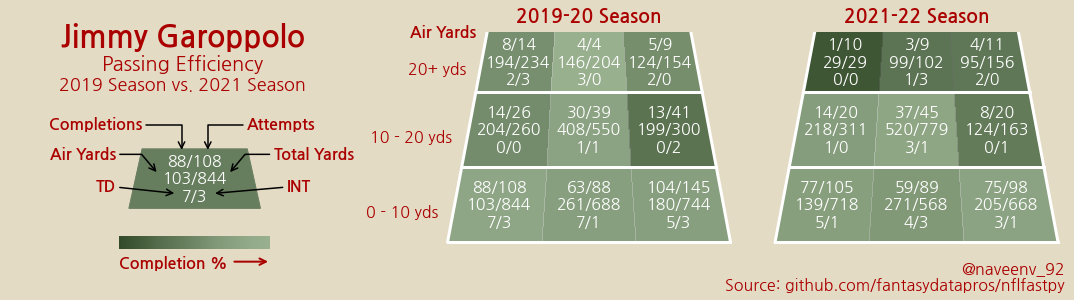

In [18]:
bg = "#e4dbc5"
grass = "#567d46"

# Plot parameters
plt.rcParams["font.family"] = "NanumGothic"
plt.rcParams["font.size"] = 16
plt.rcParams["font.weight"] = 400
plt.rcParams["text.color"] = c1
plt.rcParams["xtick.color"] = c1
plt.rcParams["ytick.color"] = c1

fig = plt.figure(figsize=(19, 4), facecolor=bg)
gs = fig.add_gridspec(nrows=5, ncols=7, width_ratios=[0.1, 0.1, 0.5, 0.1, 0.2, 1, 1], height_ratios=[0.8, 1, 1, 1, 0.3])

ax_description = fig.add_subplot(gs[:, 4], zorder=2)
ax_field_2019 = fig.add_subplot(gs[:, 5], zorder=2)
ax_field_2021 = fig.add_subplot(gs[:, 6], zorder=2)
ax_title = fig.add_subplot(gs[0:2, 0:4])
ax_legend = fig.add_subplot(gs[2:4, 1:4]) 
ax_colorbar = fig.add_subplot(gs[4, 2])
ax_buffer = fig.add_subplot(gs[1:, 0])

ax_description.set_frame_on(False)
ax_field_2019.set_frame_on(False)
ax_field_2021.set_frame_on(False)
ax_title.set_frame_on(False)
ax_legend.set_frame_on(False)
ax_colorbar.set_frame_on(False)
ax_buffer.set_frame_on(False)
ax_buffer.set(xticks=[], yticks=[])

# Sidelines
ax_field_2019.plot([0, 0.45], [0, 3], color="w", linewidth=3, zorder=3)
ax_field_2019.plot([2.55, 3], [3, 0], color="w", linewidth=3, zorder=3)

ax_field_2021.plot([0, 0.45], [0, 3], color="w", linewidth=3, zorder=3)
ax_field_2021.plot([2.55, 3], [3, 0], color="w", linewidth=3, zorder=3)

# Major Yard Lines
ax_field_2019.plot([0, 3], [0, 0], color="w", linewidth=3, zorder=3)
ax_field_2019.plot([0.15, 2.85], [1, 1], color="w", linewidth=3, zorder=3)
ax_field_2019.plot([0.3, 2.7], [2, 2], color="w", linewidth=3, zorder=3)

ax_field_2021.plot([0, 3], [0, 0], color="w", linewidth=3, zorder=3)
ax_field_2021.plot([0.15, 2.85], [1, 1], color="w", linewidth=3, zorder=3)
ax_field_2021.plot([0.3, 2.7], [2, 2], color="w", linewidth=3, zorder=3)

# Grass
field_2019 = Polygon([[0, 0], [0.45, 3], [2.55, 3], [3, 0], [0, 0]], color=grass, transform=ax_field_2019.transData, zorder=1)
ax_field_2019.add_artist(field_2019)

field_2021 = Polygon([[0, 0], [0.45, 3], [2.55, 3], [3, 0], [0, 0]], color=grass, transform=ax_field_2021.transData, zorder=1)
ax_field_2021.add_artist(field_2021)

ax_field_2019.set_xticks([])
ax_field_2019.set_yticks([])

ax_field_2021.set_xticks([])
ax_field_2021.set_yticks([])

ax_field_2019.set_xlim([-0.1, 3.1])
ax_field_2019.set_ylim([-0.1, 2.8])

ax_field_2021.set_xlim([-0.1, 3.1])
ax_field_2021.set_ylim([-0.1, 2.8])

# Title
ax_title.set(xticks=[], yticks=[])
ax_title.text(0.55, 1.1, "Jimmy Garoppolo", transform=ax_title.transAxes, ha="center", va="top", size=30, fontweight=600)
ax_title.text(0.55, 0.75, "Passing Efficiency", transform=ax_title.transAxes, ha="center", va="top", size=20)
ax_title.text(0.55, 0.5, "2019 Season vs. 2021 Season", transform=ax_title.transAxes, ha="center", va="top", size=18)

# Plot Completion Intensities
ax_field_2019.pcolormesh(X, Y, Z_2019, shading="flat", cmap="Greys_r", vmin=0, vmax=1, alpha=0.4, zorder=2)
ax_field_2021.pcolormesh(X, Y, Z_2021, shading="flat", cmap="Greys_r", vmin=0, vmax=1, alpha=0.4, zorder=2)

# Field Description
ax_description.set(xticks=[], yticks=[])

# Legend
ax_legend.set(xticks=[], yticks=[])
legend_polygon = Polygon([[0.25, 0.2], [0.3, 0.8], [0.7, 0.8], [0.75, 0.2], [0.25, 0.2]], color=grass, transform=ax_legend.transAxes, zorder=1)
legend_polygon_layer = Polygon([[0.25, 0.2], [0.3, 0.8], [0.7, 0.8], [0.75, 0.2], [0.25, 0.2]], color="gray", alpha=0.4, transform=ax_legend.transAxes, zorder=2)
ax_legend.add_artist(legend_polygon)
ax_legend.add_artist(legend_polygon_layer)
ax_legend.text(0.5, 0.5, stats_string(df_loc_agg_2019, 0, 0), ha="center", va="center", color="w")

ax_legend.annotate(
    "Completions", xy=(0.45, 0.77), xycoords="data", xytext=(0.3, 1), textcoords="data", ha="right", fontweight=600, 
    arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=0, angleB=90", linewidth=1.5)
)
ax_legend.annotate(
    "Attempts", xy=(0.55, 0.77), xycoords="data", xytext=(0.7, 1), textcoords="data", ha="left", fontweight=600,
    arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=0, angleB=90", linewidth=1.5)
)
ax_legend.annotate(
    "Air Yards", xy=(0.36, 0.55), xycoords="data", xytext=(0.2, 0.7), textcoords="data", ha="right", fontweight=600,
    arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=0, angleB=130", linewidth=1.5)
)
ax_legend.annotate(
    "Total Yards", xy=(0.63, 0.55), xycoords="data", xytext=(0.8, 0.7), textcoords="data", ha="left", fontweight=600,
    arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=0, angleB=50", linewidth=1.5)
)
ax_legend.annotate(
    "TD", xy=(0.43, 0.35), xycoords="data", xytext=(0.2, 0.35), textcoords="data", ha="right", va="bottom", fontweight=600,
    arrowprops=dict(arrowstyle="->", linewidth=1.5)
)
ax_legend.annotate(
    "INT", xy=(0.57, 0.35), xycoords="data", xytext=(0.85, 0.35), textcoords="data", ha="left", va="bottom", fontweight=600,
    arrowprops=dict(arrowstyle="->", linewidth=1.5)
)

# Colorbar
ax_colorbar.add_artist(Polygon([[0, 0], [0, 1], [1, 1], [1, 0], [0, 0]], color=grass, transform=ax_colorbar.transAxes, zorder=1))
ax_colorbar.set(xticks=[], yticks=[])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
ax_colorbar.imshow(gradient, aspect='auto', origin="lower", cmap=plt.get_cmap("Greys_r"), alpha=0.4, zorder=2)
ax_colorbar.text(0, -1, "Completion %", transform=ax_colorbar.transAxes, ha="left", va="center", fontweight=600)
ax_colorbar.annotate('', xy=(0.75, -0.9), xycoords='axes fraction', xytext=(1, -0.9), 
            arrowprops=dict(arrowstyle="<-", color=c1, linewidth=2))

# Annotations
annotate_dict = {
    (0, 0): [0.55, 0.5],
    (0, 1): [0.65, 1.5],
    (0, 2): [0.75, 2.4],
    (1, 0): [1.5, 0.5],
    (1, 1): [1.5, 1.5],
    (1, 2): [1.5, 2.4],
    (2, 0): [2.45, 0.5],
    (2, 1): [2.35, 1.5],
    (2, 2): [2.25, 2.4],
}

for i in range(3):
    for j in range(3):
        ax_field_2019.text(*annotate_dict[(i, j)], stats_string(df_loc_agg_2019, i, j), ha="center", va="center", color="w")
        ax_field_2021.text(*annotate_dict[(i, j)], stats_string(df_loc_agg_2021, i, j), ha="center", va="center", color="w")


# Descriptions
ax_description.text(-0.1, 0.4, "0 - 10 yds", transform=ax_field_2019.transData, ha="right", va="center")
ax_description.text(0.05, 1.4, "10 - 20 yds", transform=ax_field_2019.transData, ha="right", va="center")
ax_description.text(0.2, 2.3, "20+ yds", transform=ax_field_2019.transData, ha="right", va="center")
ax_description.text(0.3, 2.8, "Air Yards", transform=ax_field_2019.transData, ha="right", va="center", fontweight=600)
        
# Titles
ax_field_2019.set_title("2019-20 Season", pad=10, fontweight=600)
ax_field_2021.set_title("2021-22 Season", pad=10, fontweight=600)

# Add source
ax_field_2021.text(0.99, -0.2, "@naveenv_92\nSource: github.com/fantasydatapros/nflfastpy", ha="right", va="bottom", size=16, transform=ax_field_2021.transAxes)

plt.savefig("jimmy_garoppolo_passing.png", dpi=500, bbox_inches="tight")
plt.show()